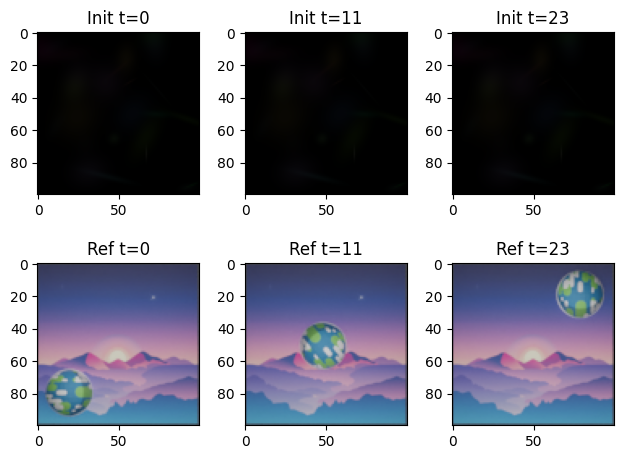

Epoch: 0
    Image iteration: 1        Loss: 0.466
    Image iteration: 2        Loss: 0.464
    Image iteration: 3        Loss: 0.462
    Image iteration: 200        Loss: 0.035
    Image iteration: 400        Loss: 0.031
    Image iteration: 600        Loss: 0.029
    Image iteration: 800        Loss: 0.027
    Image iteration: 1000        Loss: 0.027


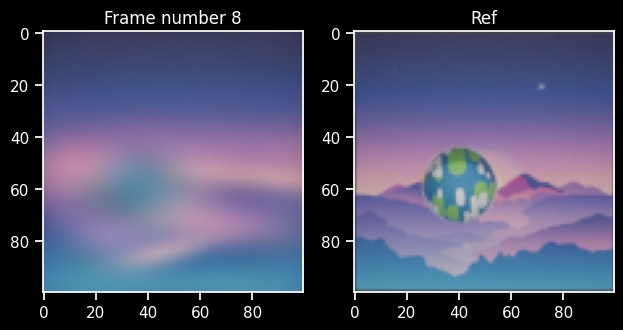

Wall time for image in h:m:s: 00:00:02
   Video iteration: 1        Loss: 0.143
   Video iteration: 2        Loss: 0.153
   Video iteration: 3        Loss: 0.175
   Video iteration: 100        Loss: 0.043
   Video iteration: 200        Loss: 0.039
   Video iteration: 300        Loss: 0.037


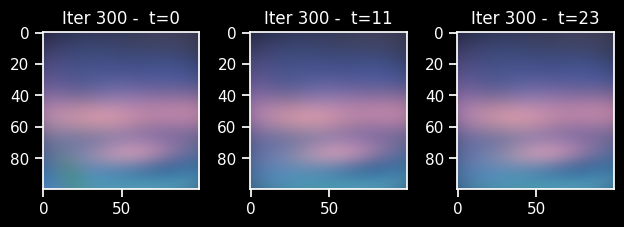

Wall time for video in h:m:s: 00:00:24
Epoch: 1
    Image iteration: 1        Loss: 0.120
    Image iteration: 2        Loss: 0.104
    Image iteration: 3        Loss: 0.088
    Image iteration: 200        Loss: 0.027
    Image iteration: 400        Loss: 0.026
    Image iteration: 600        Loss: 0.025
    Image iteration: 800        Loss: 0.025
    Image iteration: 1000        Loss: 0.024


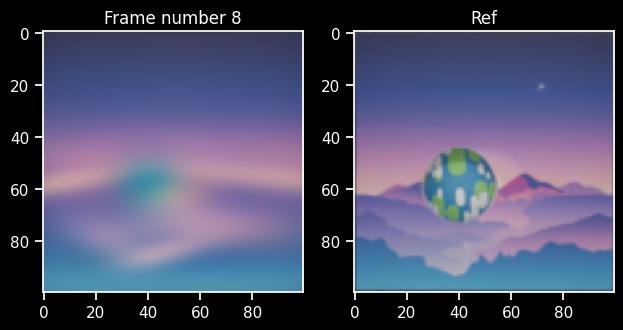

Wall time for image in h:m:s: 00:00:01
   Video iteration: 1        Loss: 0.088
   Video iteration: 2        Loss: 0.076
   Video iteration: 3        Loss: 0.067
   Video iteration: 100        Loss: 0.035
   Video iteration: 200        Loss: 0.035
   Video iteration: 300        Loss: 0.034


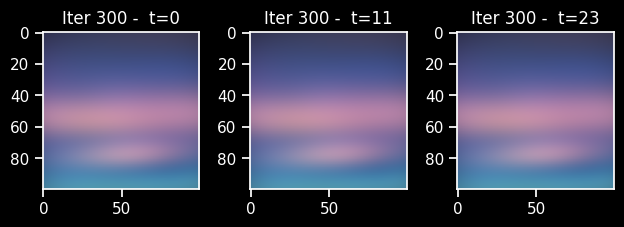

Wall time for video in h:m:s: 00:00:24
Epoch: 2
    Image iteration: 1        Loss: 0.060
    Image iteration: 2        Loss: 0.060
    Image iteration: 3        Loss: 0.047
    Image iteration: 200        Loss: 0.025
    Image iteration: 400        Loss: 0.024
    Image iteration: 600        Loss: 0.024
    Image iteration: 800        Loss: 0.024
    Image iteration: 1000        Loss: 0.024


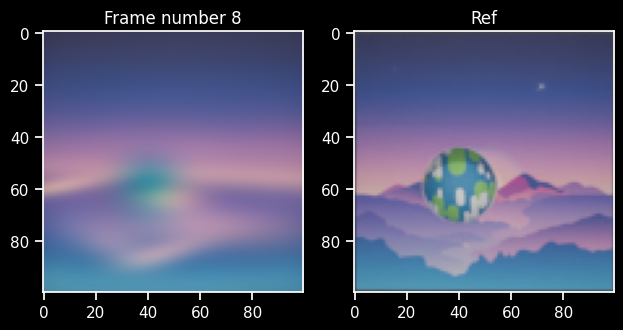

Wall time for image in h:m:s: 00:00:02
   Video iteration: 1        Loss: 0.060
   Video iteration: 2        Loss: 0.059
   Video iteration: 3        Loss: 0.052
   Video iteration: 100        Loss: 0.034
   Video iteration: 200        Loss: 0.034
   Video iteration: 300        Loss: 0.034


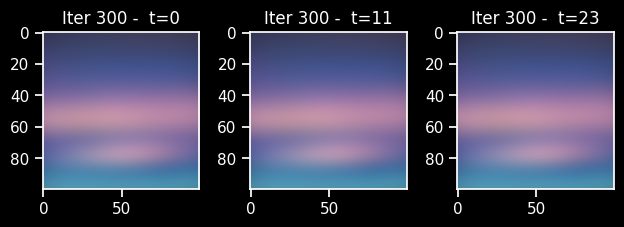

Wall time for video in h:m:s: 00:00:24
Epoch: 3
    Image iteration: 1        Loss: 0.056
    Image iteration: 2        Loss: 0.058
    Image iteration: 3        Loss: 0.045
    Image iteration: 200        Loss: 0.024
    Image iteration: 400        Loss: 0.024
    Image iteration: 600        Loss: 0.024
    Image iteration: 800        Loss: 0.024
    Image iteration: 1000        Loss: 0.024


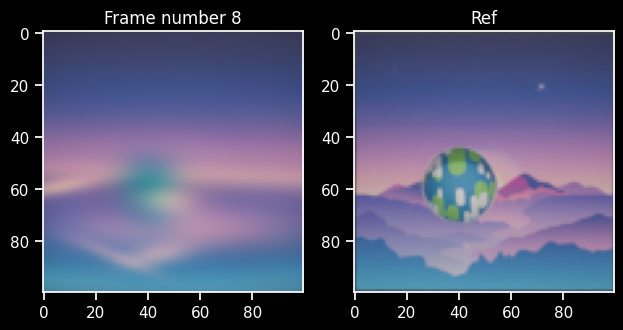

Wall time for image in h:m:s: 00:00:02
   Video iteration: 1        Loss: 0.045
   Video iteration: 2        Loss: 0.056
   Video iteration: 3        Loss: 0.048
   Video iteration: 100        Loss: 0.034
   Video iteration: 200        Loss: 0.033
   Video iteration: 300        Loss: 0.033


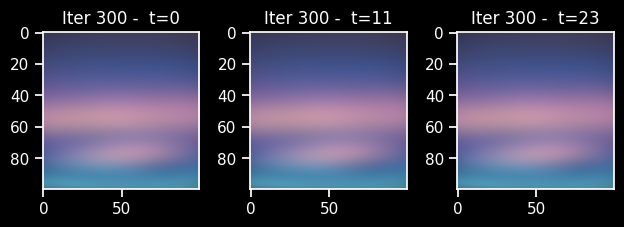

Wall time for video in h:m:s: 00:00:24
Epoch: 4
    Image iteration: 1        Loss: 0.040
    Image iteration: 2        Loss: 0.054
    Image iteration: 3        Loss: 0.040
    Image iteration: 200        Loss: 0.024
    Image iteration: 400        Loss: 0.024
    Image iteration: 600        Loss: 0.023
    Image iteration: 800        Loss: 0.023
    Image iteration: 1000        Loss: 0.023


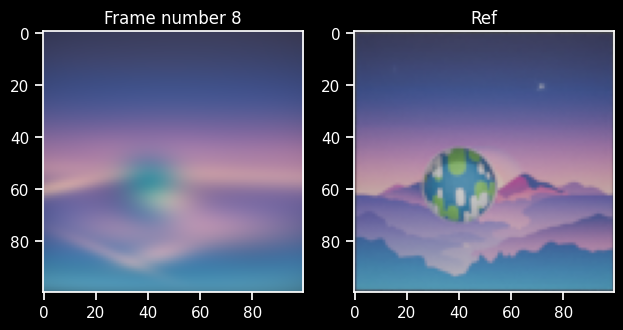

Wall time for image in h:m:s: 00:00:02
   Video iteration: 1        Loss: 0.042
   Video iteration: 2        Loss: 0.058
   Video iteration: 3        Loss: 0.047
   Video iteration: 100        Loss: 0.033
   Video iteration: 200        Loss: 0.033
   Video iteration: 300        Loss: 0.033


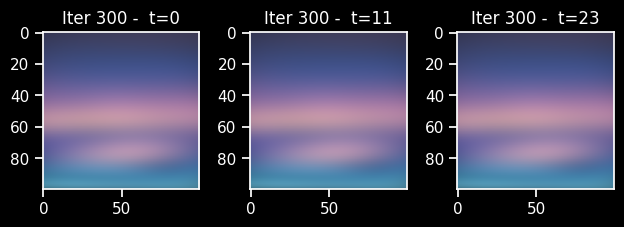

Wall time for video in h:m:s: 00:00:24

Number of params: 18253
Number of pixels: 720000


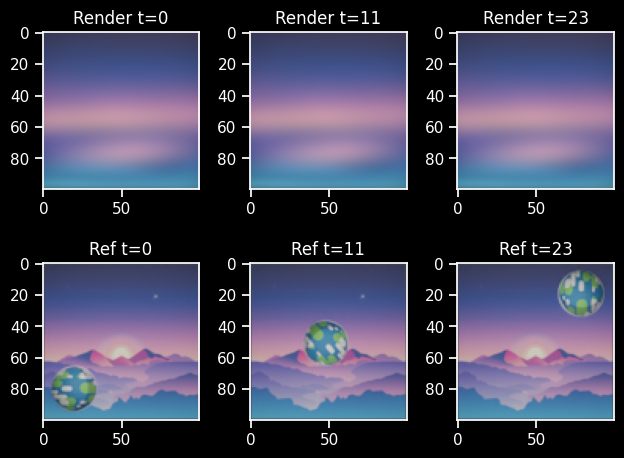

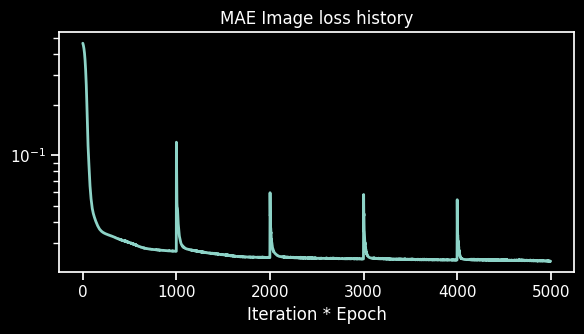

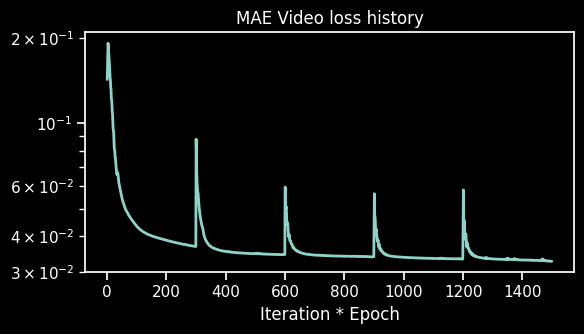

In [1]:
# import jax
from nodesplat import *
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# jax.config.update("jax_enable_x64", True)

key = jax.random.PRNGKey(3875216005)
# key = jax.random.PRNGKey(time.time_ns())
# key = None

NB_GAUSSIANS = 25
NB_EPOCHS = 5

LEARNING_RATE = 1e-1

NB_ITER_FRAME = 1000
NB_ITER_VIDEO = 300



def plot_pred_ref_videos(video, ref_video, title="Render"):
    fig, (ax) = plt.subplots(2, 3)
    sbimshow(video[0], title=title+" t=0", ax=ax[0,0])
    sbimshow(video[11], title=title+" t=11", ax=ax[0,1])
    sbimshow(video[23], title=title+" t=23", ax=ax[0,2])

    sbimshow(ref_video[0], title="Ref t=0", ax=ax[1, 0])
    sbimshow(ref_video[11], title="Ref t=11", ax=ax[1, 1])
    sbimshow(ref_video[23], title="Ref t=23", ax=ax[1, 2])
    plt.show()

def plot_pred_video(video, title="Render"):
    fig, (ax) = plt.subplots(1, 3)
    sbimshow(video[0], title=title+" t=0", ax=ax[0])
    sbimshow(video[11], title=title+" t=11", ax=ax[1])
    sbimshow(video[23], title=title+" t=23", ax=ax[2])
    plt.show()

def plot_pred_ref_images(image, ref_image, title="Render"):
    fig, (ax) = plt.subplots(1, 2)
    sbimshow(image, title=title, ax=ax[0])
    sbimshow(ref_image, title="Ref", ax=ax[1])
    plt.show()




ref_video = []
for i in range(1, 25):
    file_number = str(i).zfill(4)
    frame = plt.imread(f'earth_frames/{file_number}.png')[...,:3]/1.
    ref_video.append(frame)
ref_video = jnp.stack(ref_video, axis=0)
nb_frames, width, height, _ = ref_video.shape

model = init_changing_scene(key, ref_video, NB_GAUSSIANS)
transforms = jnp.tile(make_identity_transform(), (nb_frames, 1))
video = render_video(model.scene.gaussians, transforms, ref_video)

plot_pred_ref_videos(video, ref_video, title="Init")


all_losses_frame = []
all_losses_video = []

for epoch in range(NB_EPOCHS):
    print("Epoch:", epoch)

    ## The frame at which we ground the image
    t = jax.random.randint(key, minval=0, maxval=nb_frames, shape=())
    # t = 0


    scheduler_frame = optax.exponential_decay(LEARNING_RATE, NB_ITER_FRAME, 0.8)
    optimiser_frame = optax.adam(scheduler_frame)

    params_frame = model.scene.gaussians
    opt_state_frame = optimiser_frame.init(params_frame)

    losses_frame = []
    start_time = time.time()
    for i in tqdm(range(1, NB_ITER_FRAME+1), disable=True):
        params_frame, opt_state_frame, loss = train_step(params_frame, ref_video[t], opt_state_frame, optimiser_frame)
        losses_frame.append(loss)
        if i % 200 == 0 or i <= 3:
            print(f'    Image iteration: {i}        Loss: {loss:.3f}')
    image = render_image(params_frame, ref_video[t])
    plot_pred_ref_images(image, ref_video[t], title="Frame number "+str(t))

    wall_time = time.time() - start_time
    print("Wall time for image in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))
    
    all_losses_frame.append(losses_frame)





    scheduler = optax.exponential_decay(LEARNING_RATE, NB_ITER_VIDEO, 0.8)
    optimiser = optax.adam(scheduler)

    ## Set the objectness opf params frame to 0
    if epoch ==0:
        params_frame = params_frame.at[:, 9].set(jax.random.uniform(key, minval=0.7, maxval=1, shape=(NB_GAUSSIANS,)))

    ## Set the model gaussians as params_frame with tree_at from equinox
    where = lambda m: m.scene.gaussians
    model = eqx.tree_at(where, model, params_frame)


    # video = render_video(model.scene.gaussians, transforms, ref_video)
    # plot_pred_video(video, title="BEFORE OPTIM Iter "+str(i)+" - ")


    params, static = eqx.partition(model, eqx.is_array)
    opt_state = optimiser.init(params)

    losses = []
    start_time = time.time()
    for i in tqdm(range(1, NB_ITER_VIDEO+1), disable=True):
        params, opt_state, loss, transforms = train_step_video(params, static, ref_video, opt_state, optimiser)
        losses.append(loss)
        if i % 100 == 0 or i <= 3:
            print(f'   Video iteration: {i}        Loss: {loss:.3f}')
    video = render_video(params.scene.gaussians, transforms, ref_video)
    plot_pred_video(video, title="Iter "+str(i)+" - ")

    wall_time = time.time() - start_time
    print("Wall time for video in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))

    ## Combine everything back into the model for grounding
    model = eqx.combine(params, static)
    all_losses_video.append(losses)

## Number of params in scene
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print("\nNumber of params:", param_count)    ## Count the mlp parms as well
print("Number of pixels:", jnp.size(ref_video))

video = render_video(params.scene.gaussians, transforms, ref_video)
plot_pred_ref_videos(video, ref_video)


sbplot(np.concatenate(all_losses_frame), title="MAE Image loss history", y_scale='log', x_label="Iteration * Epoch");
sbplot(np.concatenate(all_losses_video), title="MAE Video loss history", y_scale='log', x_label="Iteration * Epoch");